In [1]:
import cifti
import numpy as np
import os
import pandas as pd
import nibabel as nb
import h5py
import cortex
import matplotlib.colors as colors
import matplotlib.pyplot as pl
%matplotlib inline

In [2]:
pkg_dir = '/Users/knapen/projects/retino_HCP/'
suffix = '' # 'NEGATIVEPRF'

orig = cifti.read('/Users/knapen/Downloads/tfMRI_RETEXP_7T_AP_Atlas_MSMAll_hp2000_clean.dtseries.nii')
series = orig[1][0]
bm = orig[1][1]

wbc = """/Applications/workbench/bin_macosx64/wb_command -cifti-separate {cii} \
COLUMN -volume-all {cii_n}_data_sub.nii \
-metric CORTEX_LEFT {cii_n}_L.gii \
-metric CORTEX_RIGHT {cii_n}_R.gii &"""

resample_cmd = """/Applications/workbench/bin_macosx64/wb_command -metric-resample \
{metric_in} {current_sphere} {new_sphere} \
ADAP_BARY_AREA {metric_out} -area-metrics {current_area} {new_area}"""


In [3]:
with h5py.File('/Users/knapen/Downloads/prfresults%s.mat'%suffix, 'r') as mat:
    allresults = mat['/allresults'].value

In [4]:
# convert the angle to radians to complex numbers, and scale r2 values to [0,1]
rads = 2*np.pi*allresults[:,:,0,:]/360
real, imag = np.sin(rads) , np.cos(rads)
newresults = np.array([real, imag, allresults[:,:,0,:], allresults[:,:,1,:], allresults[:,:,2,:], allresults[:,:,3,:], allresults[:,:,4,:]/100, allresults[:,:,5,:]]).transpose((1,2,0,3))

In [5]:
# re-code the data for weighted average subject

comp_angle = real + imag * 1j
scaled_comp_angle = comp_angle * allresults[:,:,-2,:]
scaled_ecc = newresults[:,:,3,:] * newresults[:,:,-2,:]

avg_angle = np.angle(np.mean(scaled_comp_angle, axis=1))[0]
avg_rsq = np.average(newresults[:,:,-2,:], axis=1, weights=newresults[:,:,-2,:])[0]
avg_ecc = np.average(newresults[:,:,3,:], axis=1, weights=newresults[:,:,-2,:])[0]
avg_size = np.average(newresults[:,:,7,:], axis=1, weights=newresults[:,:,-2,:])[0]

cii = '/Users/knapen/Downloads/hcp/prfresults_mean_%s.dscalar.nii'%suffix
cifti.write(cii, [avg_angle, avg_rsq, avg_ecc, avg_size], (cifti.Scalar.from_names(['ang', 'R2', 'ecc', 'rfsize']), bm))
# and convert the created cifti file to gii files
wbc_c = wbc.format(cii=cii, cii_n=cii[:-4])
os.system(wbc_c);

In [6]:
# For all subjects
for sj in range(allresults.shape[1]-1,allresults.shape[1]):
    cii = '/Users/knapen/Downloads/hcp/prfresults_%s_%03d.dscalar.nii'%(suffix,sj)
    cifti.write(cii, newresults[0,sj], (cifti.Scalar.from_names(['real', 'imag', 'ang', 'ecc', 'gain', 'meanvol', 'R2', 'rfsize']), bm))
    # and convert the created cifti file to gii files
    wbc_c = wbc.format(cii=cii, cii_n=cii[:-4])
    os.system(wbc_c)    


In [7]:
# resample to fsaverage
cs = pkg_dir + 'data/surfaces/resample_fsaverage/fs_LR-deformed_to-fsaverage.{hemi}.sphere.32k_fs_LR.surf.gii'
ns = pkg_dir + 'data/surfaces/resample_fsaverage/fsaverage_std_sphere.{hemi}.164k_fsavg_{hemi}.surf.gii'
ca = pkg_dir + 'data/surfaces/resample_fsaverage/fs_LR.{hemi}.midthickness_va_avg.32k_fs_LR.shape.gii'
na = pkg_dir + 'data/surfaces/resample_fsaverage/fsaverage.{hemi}.midthickness_va_avg.164k_fsavg_{hemi}.shape.gii'

for sj in range(allresults.shape[1]-1,allresults.shape[1]):
    for hemi in ('L', 'R'):
        mi = '/Users/knapen/Downloads/hcp/prfresults_%s_%03d.dscalar_{hemi}.gii'%(suffix,sj)
        mo = '/Users/knapen/Downloads/hcp/prfresults_%s_%03d.dscalar_fsaverage_{hemi}.gii'%(suffix,sj)
        this_cmd = resample_cmd.format(metric_in=mi.format(hemi=hemi), 
                                   current_sphere=cs.format(hemi=hemi), 
                                   new_sphere=ns.format(hemi=hemi), 
                                   metric_out=mo.format(hemi=hemi), 
                                   current_area=ca.format(hemi=hemi), 
                                   new_area=na.format(hemi=hemi))
        os.system(this_cmd)    

## KnK's analysis results plotted using pycortex

In [8]:
mo = '/Users/knapen/Downloads/hcp/prfresults_%s_183.dscalar_fsaverage_{hemi}.gii'%(suffix)

gii_files = [mo.format(hemi=hemi) for hemi in ('L','R')]
giis = [nb.load(gii_file) for gii_file in gii_files]
data=[]
for gii in giis:
   data.append(np.array([gii.darrays[i].data for i in range(len(gii.darrays))]))
data = np.hstack(data)

In [9]:
# data format: 'real', 'imag', 'ang', 'ecc', 'gain', 'meanvol', 'R2', 'rfsize'

polcomp = np.nan_to_num(data[0,:]) + np.nan_to_num(data[1,:]) * 1j

angs = np.angle(polcomp)
rsq = np.nan_to_num(data[-2,:])

angs_n = (np.nan_to_num(angs) + np.pi) / (2*np.pi)

# convert angles to colors, using correlations as weights
hsv = np.zeros(list(angs_n.shape) + [3])
hsv[..., 0] = angs_n # angs_discrete  # angs_n
hsv[..., 1] = np.ones_like(rsq) # np.sqrt(rsq) #np.ones_like(rsq)  # np.sqrt(rsq)
# np.nan_to_num(rsq ** -3) # np.ones_like(rsq)#n
hsv[..., 2] = (rsq >= 0.1).astype(float)# np.ones_like(rsq)

rgb = colors.hsv_to_rgb(hsv) * 255

red = cortex.Vertex(rgb[:,0].astype(np.uint8), subject='fsaverage', vmin=0, vmax=25)
green = cortex.Vertex(rgb[:,1].astype(np.uint8), subject='fsaverage', vmin=0, vmax=25)
blue = cortex.Vertex(rgb[:,2].astype(np.uint8), subject='fsaverage', vmin=0, vmax=25)

polar_vertex_data = cortex.VertexRGB(red, green, blue, subject='fsaverage')

# plotting is slow with db over sshfs
# cortex.quickshow(vertex_data, with_colorbar=False)
# pl.show()
# cortex.quickshow(cortex.Vertex(rsq, subject='fsaverage'), with_colorbar=False)
# pl.show()

ecc = np.nan_to_num(data[3,:])
size = np.nan_to_num(data[-1,:])

ecc[rsq<=0.1] = np.nan
size[rsq<=0.1] = np.nan

ecc_vert = cortex.Vertex(-ecc, subject='fsaverage', cmap='viridis') # , vmin1=0, vmax1=5, vmin2=0, vmax2=5, cmap='RdGn_covar'
size_vert = cortex.Vertex(-size, subject='fsaverage', cmap='viridis') # , vmin1=0, vmax1=5, vmin2=0, vmax2=5, cmap='RdGn_covar'

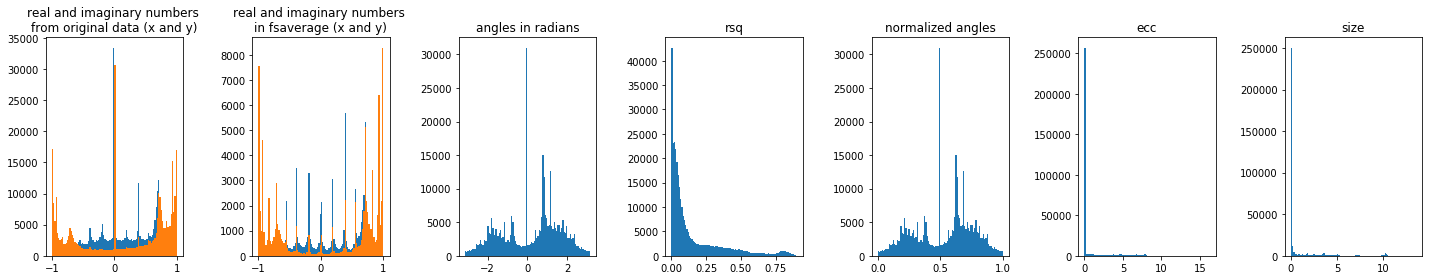

In [10]:
f, ss= pl.subplots(1,7, figsize=(20,4))
ss[0].hist(np.nan_to_num(data[0,:]), bins=100)
ss[0].hist(np.nan_to_num(data[1,:]), bins=100)
ss[0].set_title('real and imaginary numbers \nfrom original data (x and y)')
ss[1].hist(np.nan_to_num(real[0,-1]), bins=100)
ss[1].hist(np.nan_to_num(imag[0,-1]), bins=100)
ss[1].set_title('real and imaginary numbers \nin fsaverage (x and y)')

ss[2].hist(np.nan_to_num(angs), bins=100)
ss[2].set_title('angles in radians')

ss[3].hist(np.nan_to_num(rsq), bins=100)
ss[3].set_title('rsq')

ss[4].hist(np.nan_to_num(angs_n), bins=100)
ss[4].set_title('normalized angles');

ss[5].hist(np.nan_to_num(ecc), bins=100)
ss[5].set_title('ecc');

ss[6].hist(np.nan_to_num(size), bins=100)
ss[6].set_title('size');
pl.tight_layout()

In [11]:
ds = cortex.Dataset(ecc=ecc_vert, size=size_vert, polar=polar_vertex_data, rsq=cortex.Vertex(rsq, subject='fsaverage', vmin=-0.5, vmax=0.5))
cortex.webgl.show(ds, with_labels=False, with_rois=False)

Started server on port 15809


<JS: window.viewer>

In [12]:
pycortex

NameError: name 'pycortex' is not defined

## own fitting of only pRF runs, visualised using pycortex

In [13]:
# resample to fsaverage
cs = pkg_dir + 'data/surfaces/resample_fsaverage/fs_LR-deformed_to-fsaverage.{hemi}.sphere.32k_fs_LR.surf.gii'
ns = pkg_dir + 'data/surfaces/resample_fsaverage/fsaverage_std_sphere.{hemi}.164k_fsavg_{hemi}.surf.gii'
ca = pkg_dir + 'data/surfaces/resample_fsaverage/fs_LR.{hemi}.midthickness_va_avg.32k_fs_LR.shape.gii'
na = pkg_dir + 'data/surfaces/resample_fsaverage/fsaverage.{hemi}.midthickness_va_avg.164k_fsavg_{hemi}.shape.gii'

mi = pkg_dir + 'data/results/tfMRI_RETBAR1_7T_AP_Atlas_MSMAll_hp2000_clean.dtseries_{hemi}.func_bla_psc_av_est.gii'
mo = pkg_dir + 'data/results/tfMRI_RETBAR1_7T_AP_Atlas_MSMAll_hp2000_clean.dtseries_{hemi}.func_bla_psc_av_est_fsaverage.gii'

for hemi in ('L', 'R'):
    gii_file = mi.format(hemi=hemi)
    gii = nb.load(gii_file)
    data32 = np.array([gii.darrays[i].data for i in range(len(gii.darrays))]).astype(np.float32)
    darrays = [nb.gifti.gifti.GiftiDataArray(d) for d in data32]
    gii_out = nb.gifti.gifti.GiftiImage(header=gii.header, 
                            extra=gii.extra,
                            darrays=darrays)
    
    out_file = os.path.abspath(os.path.splitext(gii_file)[0] + '_f32.gii')
    nb.save(gii_out, out_file)
    
    
    # conversion to fsaverage
    this_cmd = resample_cmd.format(metric_in=out_file, 
                               current_sphere=cs.format(hemi=hemi), 
                               new_sphere=ns.format(hemi=hemi), 
                               metric_out=mo.format(hemi=hemi), 
                               current_area=ca.format(hemi=hemi), 
                               new_area=na.format(hemi=hemi))
    os.system(this_cmd)  
    print(this_cmd)

/Applications/workbench/bin_macosx64/wb_command -metric-resample /Users/knapen/projects/retino_HCP/data/results/tfMRI_RETBAR1_7T_AP_Atlas_MSMAll_hp2000_clean.dtseries_L.func_bla_psc_av_est_f32.gii /Users/knapen/projects/retino_HCP/data/surfaces/resample_fsaverage/fs_LR-deformed_to-fsaverage.L.sphere.32k_fs_LR.surf.gii /Users/knapen/projects/retino_HCP/data/surfaces/resample_fsaverage/fsaverage_std_sphere.L.164k_fsavg_L.surf.gii ADAP_BARY_AREA /Users/knapen/projects/retino_HCP/data/results/tfMRI_RETBAR1_7T_AP_Atlas_MSMAll_hp2000_clean.dtseries_L.func_bla_psc_av_est_fsaverage.gii -area-metrics /Users/knapen/projects/retino_HCP/data/surfaces/resample_fsaverage/fs_LR.L.midthickness_va_avg.32k_fs_LR.shape.gii /Users/knapen/projects/retino_HCP/data/surfaces/resample_fsaverage/fsaverage.L.midthickness_va_avg.164k_fsavg_L.shape.gii
/Applications/workbench/bin_macosx64/wb_command -metric-resample /Users/knapen/projects/retino_HCP/data/results/tfMRI_RETBAR1_7T_AP_Atlas_MSMAll_hp2000_clean.dtseri

In [14]:
gii_files = [mo.format(hemi=hemi) for hemi in ('L','R')]
giis = [nb.load(gii_file) for gii_file in gii_files]
data=[]
for gii in giis:
   data.append(np.array([gii.darrays[i].data for i in range(len(gii.darrays))]))
data = np.hstack(data)

In [15]:
# data format: 'real', 'imag', 'ang', 'ecc', 'gain', 'meanvol', 'R2', 'rfsize'

polcomp = np.nan_to_num(-data[0,:]) - np.nan_to_num(data[1,:]) * 1j

angs = np.angle(polcomp)
rsq = np.nan_to_num(data[-1,:])
s_rsq = rsq * np.sign(data[4,:])
angs_n = (np.nan_to_num(angs) + np.pi) / (2*np.pi)

# convert angles to colors, using correlations as weights
hsv = np.zeros(list(angs_n.shape) + [3])
hsv[..., 0] = angs_n # angs_discrete  # angs_n
hsv[..., 1] = np.ones_like(rsq) # np.sqrt(rsq) #np.ones_like(rsq)  # np.sqrt(rsq)
# np.nan_to_num(rsq ** -3) # np.ones_like(rsq)#n
hsv[..., 2] = (rsq >= 0.1).astype(float)# np.ones_like(rsq)

rgb = colors.hsv_to_rgb(hsv) * 255

red = cortex.Vertex(rgb[:,0].astype(np.uint8), subject='fsaverage', vmin=0, vmax=25)
green = cortex.Vertex(rgb[:,1].astype(np.uint8), subject='fsaverage', vmin=0, vmax=25)
blue = cortex.Vertex(rgb[:,2].astype(np.uint8), subject='fsaverage', vmin=0, vmax=25)

polar_vertex_data = cortex.VertexRGB(red, green, blue, subject='fsaverage')

# plotting is slow with db over sshfs
# cortex.quickshow(vertex_data, with_colorbar=False)
# pl.show()
# cortex.quickshow(cortex.Vertex(rsq, subject='fsaverage'), with_colorbar=False)
# pl.show()

ecc = np.nan_to_num(data[2,:])
size = np.nan_to_num(data[4,:])

ecc[rsq<=0.1] = np.nan
size[rsq<=0.1] = np.nan

ecc_vert = cortex.Vertex(-ecc, subject='fsaverage', cmap='viridis') # , vmin1=0, vmax1=5, vmin2=0, vmax2=5, cmap='RdGn_covar'
size_vert = cortex.Vertex(-size, subject='fsaverage', cmap='viridis') # , vmin1=0, vmax1=5, vmin2=0, vmax2=5, cmap='RdGn_covar'

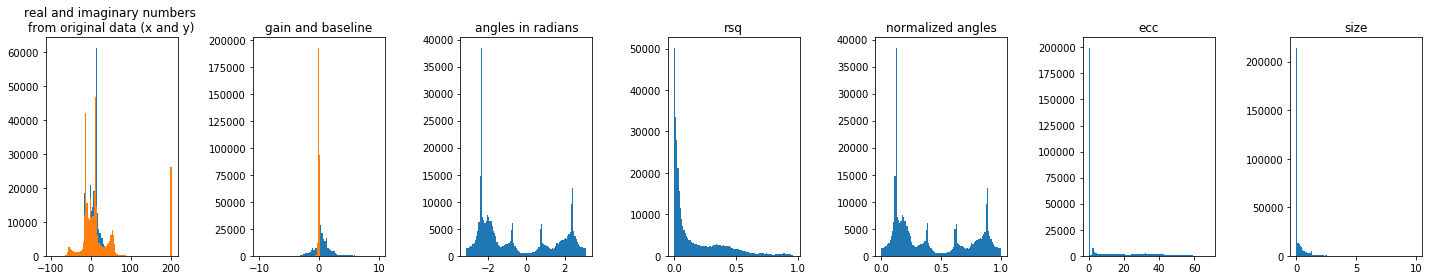

In [16]:
f, ss= pl.subplots(1,7, figsize=(20,4))
ss[0].hist(np.nan_to_num(data[0,:]), bins=100)
ss[0].hist(np.nan_to_num(data[1,:]), bins=100)
ss[0].set_title('real and imaginary numbers \nfrom original data (x and y)')
ss[1].hist(np.nan_to_num(data[4,:]), bins=100, range=[-10,10])
ss[1].hist(np.nan_to_num(data[5,:]), bins=100, range=[-10,10])
ss[1].set_title('gain and baseline')

ss[2].hist(np.nan_to_num(angs), bins=100)
ss[2].set_title('angles in radians')

ss[3].hist(np.nan_to_num(rsq), bins=100)
ss[3].set_title('rsq')

ss[4].hist(np.nan_to_num(angs_n), bins=100)
ss[4].set_title('normalized angles');

ss[5].hist(np.nan_to_num(ecc), bins=100)
ss[5].set_title('ecc');

ss[6].hist(np.nan_to_num(size), bins=100, range=[0,10])
ss[6].set_title('size');
pl.tight_layout()

In [17]:
ds = cortex.Dataset(ecc=ecc_vert, size=size_vert, polar=polar_vertex_data, rsq=cortex.Vertex(s_rsq, subject='fsaverage', vmin=-0.5, vmax=0.5))
cortex.webgl.show(ds, with_labels=False, with_rois=False)

Started server on port 1983


<JS: window.viewer>